# TPU

2023-09-01 05:19:32.774409: E tensorflow/core/framework/op_kernel.cc:1676] OpKernel ('op: "TPURoundRobin" device_type: "CPU"') for unknown op: TPURoundRobin
2023-09-01 05:19:32.774453: E tensorflow/core/framework/op_kernel.cc:1676] OpKernel ('op: "TpuHandleToProtoKey" device_type: "CPU"') for unknown op: TpuHandleToProtoKey


CUDA available: False
TPU available: xla:1


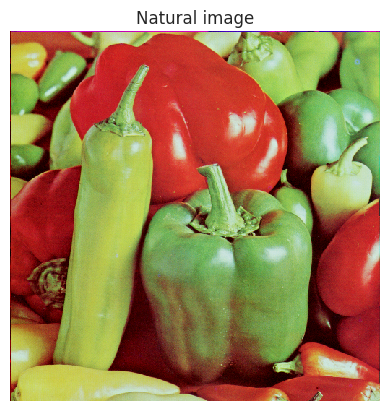

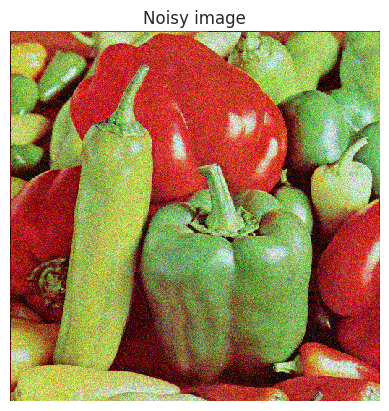

In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt

import sys
import numpy as np
from models import *
import torch
import torch.optim
from torch.optim import Optimizer
import time
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *
import _pickle as cPickle
import seaborn as sns


import os
import torch_xla.core.xla_model as xm

TPU_IP_ADDRESS = '10.119.164.98'
os.environ['TPU_IP_ADDRESS'] = TPU_IP_ADDRESS
os.environ['XRT_TPU_CONFIG'] = f"tpu_worker;0;{TPU_IP_ADDRESS}:8470"

# Initialize TPU device
device = xm.xla_device()

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# display images
def np_plot(np_matrix, title):
    plt.clf()
    fig = plt.imshow(np_matrix.transpose(1, 2, 0), interpolation = 'nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)
    plt.axis('off')
    plt.pause(0.05) 

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('TPU available: {}'.format(xm.xla_device()))

fname = 'data/denoising/Dataset/image_Peppers512rgb.png'
imsize =-1
sigma = 25/255.
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)                
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma)
np_plot(img_np, 'Natural image')
np_plot(img_noisy_np, 'Noisy image')


INPUT = 'noise'
pad = 'reflection'
OPT_OVER = 'net' # optimize over the net parameters only
reg_noise_std = 1./30.
learning_rate = LR = 0.01
exp_weight=0.99
input_depth = 32 
roll_back = True # to prevent numerical issues
burnin_iter = 7000 # burn-in iteration for SGLD
weight_decay = 5e-8
show_every =  500
mse = torch.nn.MSELoss().type(dtype) # loss
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
img_torch = np_to_torch(img_np).type(dtype)

In [2]:

class SGLD(Optimizer):
    """ Stochastic Gradient Langevin Dynamics Sampler with preconditioning.
        Optimization variable is viewed as a posterior sample under Stochastic
        Gradient Langevin Dynamics with noise rescaled in eaach dimension
        according to RMSProp.
    """
    def __init__(self,
                 params,
                 lr=1e-2,
                 precondition_decay_rate=0.95,
                 num_pseudo_batches=1,
                 num_burn_in_steps=3000,
                 diagonal_bias=1e-8) -> None:
        """ Set up a SGLD Optimizer.

            Parameters
            ----------
            params : iterable
                Parameters serving as optimization variable.
            lr : float, optional
                Base learning rate for this optimizer.
                Must be tuned to the specific function being minimized.
                Default: `1e-2`.
            precondition_decay_rate : float, optional
                Exponential decay rate of the rescaling of the preconditioner (RMSprop).
                Should be smaller than but nearly `1` to approximate sampling from the posterior.
                Default: `0.95`
            num_pseudo_batches : int, optional
                Effective number of minibatches in the data set.
                Trades off noise and prior with the SGD likelihood term.
                Note: Assumes loss is taken as mean over a minibatch.
                Otherwise, if the sum was taken, divide this number by the batch size.
                Default: `1`.
            num_burn_in_steps : int, optional
                Number of iterations to collect gradient statistics to update the
                preconditioner before starting to draw noisy samples.
                Default: `3000`.
            diagonal_bias : float, optional
                Term added to the diagonal of the preconditioner to prevent it from
                degenerating.
                Default: `1e-8`.

            """
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if num_burn_in_steps < 0:
            raise ValueError("Invalid num_burn_in_steps: {}".format(num_burn_in_steps))

        defaults = dict(
            lr=lr, precondition_decay_rate=precondition_decay_rate,
            num_pseudo_batches=num_pseudo_batches,
            num_burn_in_steps=num_burn_in_steps,
            diagonal_bias=1e-8,
        )
        # Use XLA device for TPU support
        self.device = xm.xla_device()

        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()


        # Inside your step method
        for group in self.param_groups:
            for parameter in group["params"]:
                if parameter.grad is None:
                    continue

                # The state can remain on the CPU
                state = self.state[parameter]

                # Move parameters and grads to TPU
                parameter = parameter.to(self.device)
                gradient = parameter.grad.data.to(self.device)

                lr = group["lr"]
                num_pseudo_batches = group["num_pseudo_batches"]
                precondition_decay_rate = group["precondition_decay_rate"]

                # Initialize state if it's empty
                if len(state) == 0:
                    state["iteration"] = 0
                    state["momentum"] = torch.ones_like(parameter).to(self.device)
                
                state["iteration"] += 1

                # Move momentum to TPU
                momentum = state["momentum"].to(self.device)

                #  Momentum update {{{ #
                momentum.add_(
                    (1.0 - precondition_decay_rate) * ((gradient ** 2) - momentum)
                )
                #  }}} Momentum update #

                if state["iteration"] > group["num_burn_in_steps"]:
                    sigma = 1. / torch.sqrt(torch.tensor(lr))
                else:
                    sigma = torch.zeros_like(parameter)

                preconditioner = (
                    1. / torch.sqrt(momentum + group["diagonal_bias"])
                )

                scaled_grad = (
                    0.5 * preconditioner * gradient * num_pseudo_batches +
                    torch.normal(
                        mean=torch.zeros_like(gradient),
                        std=torch.ones_like(gradient)
                    ) * sigma * torch.sqrt(preconditioner)
                )

                parameter.data.add_(-lr * scaled_grad)

        return loss


In [3]:
sgld_psnr_list = [] # psnr between sgld out and gt
sgld_mean = 0
roll_back = True # To solve the oscillation of model training 
last_net = None
psrn_noisy_last = 0
MCMC_iter = 50
param_noise_sigma = 2

sgld_mean_each = 0
sgld_psnr_mean_list = [] # record the PSNR of avg after burn-in

sample_count = 0  # Initialize your sample_count
sgld_mean = 0  # Initialize your sgld_mean

i = 0
i = torch.tensor(i, dtype=torch.int)
burnin_iter = torch.tensor(burnin_iter, dtype=torch.int)
MCMC_iter = torch.tensor(MCMC_iter, dtype=torch.int)
sgld_mean = torch.tensor(sgld_mean, dtype=torch.float32)
sample_count = torch.tensor(sample_count, dtype=torch.float32)


device = xm.xla_device()

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach().to(device)
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

# Move other tensors to device if needed
img_noisy_torch = img_noisy_torch.to(device)

sample_count = 0

def closure_sgld():
    global i, net_input, sgld_mean, sample_count, psrn_noisy_last, last_net, sgld_mean_each
    if reg_noise_std > 0: # reg_noise_std is always 1/30
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = model(net_input)
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()


    # psrn_noisy = psnr_tensor(img_noisy_torch, out)
    # psrn_gt    = psnr_tensor(img_torch, out)
    
    # if i > burnin_iter and (i % MCMC_iter == 0):
    #     sgld_mean += out
    #     sample_count += 1.


    # if i > burnin_iter:
    #     sgld_mean_each += out
    #     sgld_mean_tmp = sgld_mean_each / (i - burnin_iter)
    #     sgld_mean_psnr_each = psnr_tensor(img_torch, sgld_mean_tmp)
    #     print('Iter: %d; psnr_gt %.2f; psnr_sgld %.2f' % (i, psrn_gt, sgld_mean_psnr_each))
    # else:
    #     print('Iter: %d; psnr_gt %.2f; loss %.5f' % (i, psrn_gt, total_loss))
    
    # if i == burnin_iter:
    #     print('Burn-in done, start sampling')

    i += 1

    return total_loss

def psnr_tensor(img1, img2, max_val=1.0):
    """Compute Peak Signal-to-Noise Ratio (the higher the better).

    img1 and img2 have range [0, max_val]
    """
    img1 = img1.to(torch.float32)
    img2 = img2.to(torch.float32)
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * torch.log10(max_val ** 2 / mse)

In [4]:

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=32, out_channels=3, init_features=128, pretrained=False)
model = model.to(device)



Using cache found in /home/joe/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [5]:
# Initialize the SGLD optimizer
print('Starting optimization with SGLD')
num_iter = 500 # max iterations

optimizer = SGLD(
    model.parameters(), 
    lr=LR,
    precondition_decay_rate=1-5e-8,
    num_burn_in_steps=7000
    )  # SGLD hyperparameters here, if any
    
# Replace Adam optimizer with SGLD in the training loop
for j in range(num_iter):
    print('Iteration %05d/%05d' % (j + 1, num_iter))
    optimizer.zero_grad()
    
    loss = closure_sgld()  # Assuming closure_sgld() computes the loss and performs backward
    
    # net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    # out = model(net_input)
    # total_loss = mse(out, img_noisy_torch)
    # print('Iter: %d; loss %.5f' % (j, total_loss))
    # total_loss.backward()

    optimizer.step()
    xm.mark_step()
    
sgld_mean = sgld_mean / sample_count  # Finalize your sgld_mean
sgld_mean_psnr = compare_psnr(img_np, sgld_mean)  # Compute PSNR

Starting optimization with SGLD
Iteration 00001/20000
Iteration 00002/20000
Iteration 00003/20000
Iteration 00004/20000
Iteration 00005/20000
Iteration 00006/20000
Iteration 00007/20000
Iteration 00008/20000
Iteration 00009/20000
Iteration 00010/20000
Iteration 00011/20000
Iteration 00012/20000
Iteration 00013/20000
Iteration 00014/20000
Iteration 00015/20000
Iteration 00016/20000
Iteration 00017/20000
Iteration 00018/20000
Iteration 00019/20000
Iteration 00020/20000
Iteration 00021/20000
Iteration 00022/20000
Iteration 00023/20000
Iteration 00024/20000
Iteration 00025/20000
Iteration 00026/20000
Iteration 00027/20000
Iteration 00028/20000
Iteration 00029/20000
Iteration 00030/20000
Iteration 00031/20000
Iteration 00032/20000
Iteration 00033/20000
Iteration 00034/20000
Iteration 00035/20000
Iteration 00036/20000
Iteration 00037/20000
Iteration 00038/20000
Iteration 00039/20000
Iteration 00040/20000
Iteration 00041/20000
Iteration 00042/20000
Iteration 00043/20000
Iteration 00044/20000


KeyboardInterrupt: 

In [ ]:
# print out the shape of img_np
print('img_np shape: %f' % img_np.shape)